In [19]:
"""Startup"""
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re
import numpy as np
import pickle
from IPython.display import clear_output




from sklearn.naive_bayes import MultinomialNB
import time


globalDataSet = pd.DataFrame(columns=['data', 'grade'])


pathToDataCollectorDatabase = 'D:\\PythonTestMid'

# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        
def searchFiles(path, fileformats):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            for fileformat in fileformats:
                if file.endswith(fileformat):
                    #code to generate a list of paths of files to generate logs for
                    filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                #code to generate a list of paths of files to generate logs for
                filesToDo.append(os.path.join(root, file).removeprefix(path))
    return filesToDo

In [29]:
#Generate a list of files to index
filesToIndex = searchFileName(pathToDataCollectorDatabase,"gitinfo.txt")
print("generated Files to index")
#Create a dataframe that contains the data of the gitinfo.txt files
import json
import warnings
warnings.filterwarnings('ignore')
i=0
#example of the gitinfo.txt file    {"id": 3452233, "name": "hjlebbink/asm-dude", "isFork": false, "commits": 939, "branches": 8, "defaultBranch": "master", "releases": 39, "contributors": 10, "license": "MIT License", "watchers": 762, "stargazers": 3906, "forks": 76, "size": 82262, "createdAt": "2016-02-19 03:43:23", "pushedAt": "2022-01-06 01:33:34", "updatedAt": "2022-01-08 08:02:49", "homepage": "", "mainLanguage": "Python", "totalIssues": 118, "openIssues": 32, "totalPullRequests": 13, "openPullRequests": 1, "lastCommit": "2021-12-07 08:47:07", "lastCommitSHA": "1e1e3dc2364e8ed549ba404868b6473ba435b25c", "hasWiki": true, "isArchived": false, "languages": {"Python": 4274689, "C#": 2554588, "C": 1311140, "C++": 644077, "Assembly": 164163, "Shell": 2764, "Go": 1779, "Batchfile": 410}, "labels": ["bug", "duplicate", "enhancement", "help wanted", "invalid", "question", "wontfix"]}
df = pd.DataFrame(columns=['id', 'name', 'isFork', 'commits', 'branches', 'defaultBranch', 'releases', 'contributors', 'license', 'watchers', 'stargazers', 'forks', 'size', 'createdAt', 'pushedAt', 'updatedAt', 'homepage', 'mainLanguage', 'totalIssues', 'openIssues', 'totalPullRequests', 'openPullRequests', 'lastCommit', 'lastCommitSHA', 'hasWiki', 'isArchived', 'languages', 'labels' , 'path'])
for file in filesToIndex:
    #print progress bar
    printProgressBar(i, len(filesToIndex), prefix = 'Progress:', suffix = 'Complete', length = 50)
    with open(pathToDataCollectorDatabase + file, 'r') as f:
        d = json.load(f)
    f.close()
    dftemp = pd.json_normalize(d)
    dftemp['path'] = file.removesuffix('gitinfo.txt')
    df = pd.concat([df, dftemp], ignore_index=True)
    i = i+1


generated Files to index


In [3]:
#save the index dataframe
df.to_csv(pathToDataCollectorDatabase + '\\gitinfo.csv', index=False)

In [27]:
#load the index dataframe
import json
import warnings
df = pd.read_csv(pathToDataCollectorDatabase + '\\gitinfo.csv')

In [75]:
#Grading V2
import numpy as np
import requests

fileformatToUse = ".txt"
useGITAPI = False
addRepoToData = True


#commit comment keywords for code grade adjustment
positiveKeyWords = ['fix', 'resolve', 'resolve', 'resolved', 'resolves', 'resolving', 'close', 'closed', 'closes', 'closing', 'fixes', 'fixed', 'fixing', 'patch', 'patched', 'patching', 'update', 'updated', 'updating', 'upgrade', 'upgraded', 'upgrading', 'improve', 'improved', 'improving', 'improvement', 'improvements', 'improves', 'improving', 'enhance', 'enhanced', 'enhances', 'enhancing', 'enhancement', 'enhancements']
positiveKeyWordsBigImpact = ['Signed-off', 'Merge', 'Merged']
positiveKeyWordsValue = 1
positiveKeyWordsBigImpactValue = 5
negitiveKeyWords = ['todo','tofix','bugged','fix me','fix-me']
negitiveKeyWordsValue = -1

prevCommitScoreAdjustmentNegitiveKeyWords = ['revert','reverted','reverting','reverts']
prevCommitScoreAdjustmentNegitiveKeyWordsValue = -10



import numpy as np
filesToIndex = df['path'].tolist()
#Create an array of strings of folders which contain a 0.txt file
foldersWithCommits = []
for file in filesToIndex:
    for filelvl2 in searchFileName(pathToDataCollectorDatabase+file, "0.txt"):
        #print(pathToDataCollectorDatabase+file+filelvl2.removesuffix('0.txt'))
        if (searchFiles(pathToDataCollectorDatabase+file+filelvl2.removesuffix('0.txt'), fileformatToUse) != []):
            foldersWithCommits.append(file+filelvl2.removesuffix('0.txt'))
            





#get the total number of commits for each folder
totalCommits = []
for folder in foldersWithCommits:
    totalCommits.append(len(searchFiles(pathToDataCollectorDatabase+folder, ['.txt'])))

dataSet1 = pd.DataFrame(columns=['data', 'grade'])
if (addRepoToData):
    dataSet1 = pd.DataFrame(columns=['data', 'grade', 'repo'])
repositoryName = ''
prevRepositoryName = ''
repoInfo = ''
#make multitheaded

index = 0
for i in foldersWithCommits:
    printProgressBar(index, len(foldersWithCommits), prefix = 'Progress:', suffix = 'Complete', length = 50)
    index = index + 1
    authorsEmail = []
    authors = []
    repositoryName = i.split('\\')[1]

    if (repositoryName != prevRepositoryName):
        data = open(pathToDataCollectorDatabase+'\\' + repositoryName+'\\gitinfo.txt', 'r', encoding="utf8")
        repoInfo = json.loads(data.read())
        data.close()
    repoBaseScore = 0
    #subtract the dates from creation date and last updated date to get an age score
    import datetime
    #'%Y-%m-%d T%H:%M:%SZ'
    repoAge = (datetime.datetime.strptime(repoInfo['updatedAt'], '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(repoInfo['createdAt'], '%Y-%m-%d %H:%M:%S'))
    repoAge = repoAge.days
    #The older the repo the higher the score
    ageScore = 200 - (repoAge/365)*100
    #add a score based on the number of contributors
    contributorRepoScore = repoInfo['contributors']*5
    #add a score based on the number of stars
    starScore = repoInfo['stargazers'] * 10
    #add a score based on the number of forks
    forkScore = repoInfo['forks'] * 10
    #add a score based on the number of watchers
    watchScore = repoInfo['watchers'] * 10
    #add a score based on the number of issues
    repoBaseScore = repoBaseScore + (repoInfo['totalIssues'] * 10)
    totIssues = repoInfo['totalIssues']
    opIssues = repoInfo['openIssues']
    if (opIssues != 0):
        issuesScore = 90 - (totIssues/opIssues)*100
    else:
        issuesScore = -1


    #get the top 2 scores
    top2Scores = sorted([ageScore, contributorRepoScore, starScore, forkScore, watchScore, issuesScore], reverse=True)[:2]
    #add the top 2 scores together
    repoBaseScore = repoBaseScore + top2Scores[0] + top2Scores[1]
    repoBaseScore = repoBaseScore/50
    if (issuesScore == -1):
        repoBaseScore = repoBaseScore -15



    
    numberOfCommits = len(searchFiles(pathToDataCollectorDatabase+i, ['.txt']))

    #prevContributors = []      Maybe for future use
    #prevContributorsAmount = []

    for j in range(len(searchFiles(pathToDataCollectorDatabase+i, ['.txt']))):

        authorsEmailCache = authorsEmail.copy()
        skip = False
        
        try :
            data = open(pathToDataCollectorDatabase+i+str(j)+fileformatToUse, 'r', encoding="utf8")
            commitdata = data.read()
            data.close()
            data1 = open(pathToDataCollectorDatabase+i+str(j)+'.json', 'r', encoding="utf8")
            commitinfo = data1.read()
            data1.close()
        except:
            #print("Error opening file: "+pathToDataCollectorDatabase+i+str(j)+fileformatToUse)
            commitdata = ''
            commitinfo = ''
            continue

        #get the number of contributors
        #error checking
        try:
            contributors = commitinfo.split('author\':')[1]
            contributors = contributors.split('\'date\':')[0]
            contributorscount = contributors.count("<")
        except:
            break
            print("error file = " + i+str(j)+".json")

        if (commitdata == ''):
            break
        contributorScore = contributorscount -1

        #find KeyWords in the commit message
        commitmessage = commitinfo.split('\'summary\':')[1]
        commitmessage = commitmessage.replace(', \'description\':', ' ')

        keyWordAdjustment = 0
        prevCommitAdjustment = 0
        #check the commit message for the words in positiveKeyWords
        for word in positiveKeyWords:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + positiveKeyWordsValue
        
        #check the commit message for the words in positiveKeyWordsBigImpact
        for word in positiveKeyWordsBigImpact:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + positiveKeyWordsBigImpactValue

        #check the commit message for the words in negitiveKeyWords
        for word in negitiveKeyWords:
            if (commitmessage.find(word) != -1):
                keyWordAdjustment = keyWordAdjustment + negitiveKeyWordsValue

        #check the commit message for the words in prevCommitScoreAdjustmentNegitiveKeyWords
        for word in prevCommitScoreAdjustmentNegitiveKeyWords:
            if (commitmessage.find(word) != -1):
                prevCommitAdjustment = prevCommitAdjustment + prevCommitScoreAdjustmentNegitiveKeyWordsValue
        """Impliment this later"""
        #if (prevCommitAdjustment != 0):
            #dataSet1['grade'].last = dataSet1['grade'].last + prevCommitAdjustment

        topBaseScoreAddition = 50
        topContributorScoreAddition = 15
        topKeyWordScoreAddition = 15
        topCommitNumbScoreAddition = 20

        if (keyWordAdjustment > 5):
            KeyWordAdjustment = 5
        if (keyWordAdjustment < -5):
            KeyWordAdjustment = -5

        if (contributorscount > 3):
            contributorscount = 3

        finalKeywordScore = (keyWordAdjustment/5)*topKeyWordScoreAddition
        finalContributorScore = ((contributorScore/3)*topContributorScoreAddition)
        finalCommitScore = (topCommitNumbScoreAddition * (j / numberOfCommits))

        if(repoBaseScore > topBaseScoreAddition):
            repoBaseScore = topBaseScoreAddition


        commitGrade = np.clip(repoBaseScore + finalKeywordScore + finalContributorScore + finalCommitScore, 0,100)
        """if (commitGrade == 55):
            print(repoBaseScore)
            print(finalKeywordScore)
            print(finalContributorScore)
            print(finalCommitScore)"""
        dataSet1temp = pd.DataFrame({'data': [commitdata], 'grade': [commitGrade]})
        if (addRepoToData):
            dataSet1temp['repo'] = i
        dataSet1 = pd.concat([dataSet1, dataSet1temp], ignore_index=True)

        

        #calculate Grade
        #create a minimum grade based off of stats from the github repo

        #get the authors info if using the GITHUB API. Maybe make into a seperate application that can then be used to generate a json file used here due to the rate limit of the API
        if (useGITAPI == True):
            authorsArray = contributors.split('>')
            for author in authorsArray:
                if (author.find('<') != -1):
                    authorsEmail.append(author[author.find('<')+1:])
            #use https://api.github.com/search/users?q= to get a username from an email address
            for author in authorsEmail:
                print(authorsEmailCache)
                if (author.find('@') != -1 and not (author in authorsEmailCache)):
                    print (author + 'test')
                    gitRequest = requests.get('https://api.github.com/search/users?q='+author).json()
                    if (gitRequest['total_count'] > 0):
                        authors.append(gitRequest['items'][0]['login'])
                        print("shouldn't show up")

                    #print (requests.get('https://api.github.com/search/users?q='+author).json()['items'][0]['login'])

    

dataSet1['grade'].value_counts()


50.000000    1090
53.000000     237
60.000000     216
9.400000      213
65.000000     205
             ... 
72.111111       1
73.222222       1
73.555556       1
78.777778       1
33.300000       1
Name: grade, Length: 5016, dtype: int64

In [5]:
#save the grading databse to the database folder
dataSet1.to_csv(pathToDataCollectorDatabase + '\\dataSet1Grade.csv', index=False)

In [71]:
#load the grading databse from the database folder
dataSet1 = pd.read_csv(pathToDataCollectorDatabase + '\\dataSet1Grade.csv')

<AxesSubplot: title={'center': 'Grade Distribution'}>

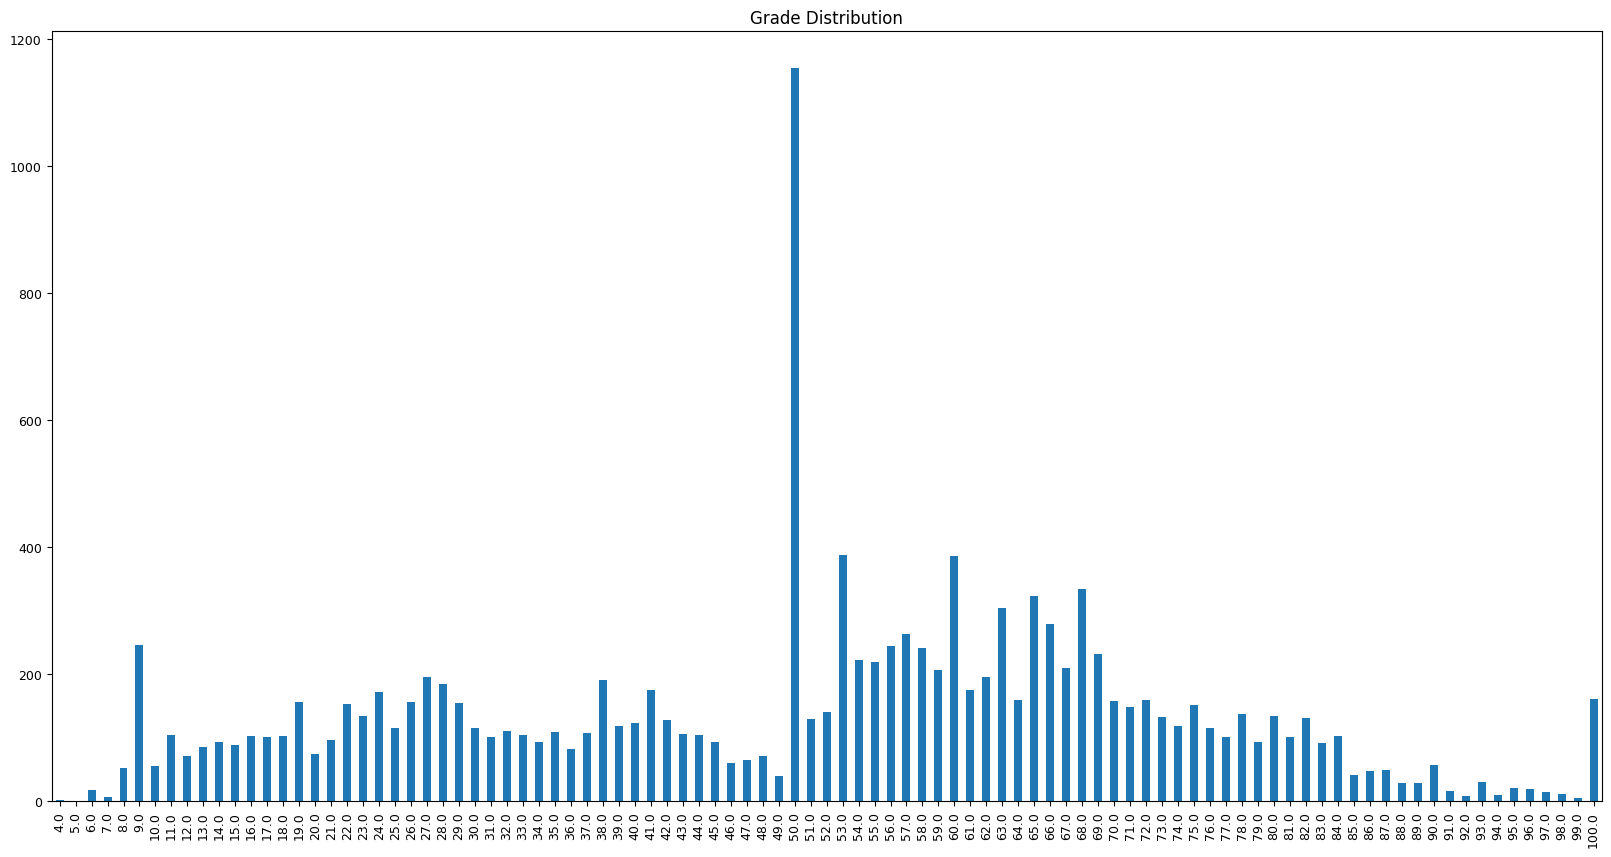

In [70]:
#create a chart of the grades
round(dataSet1['grade']).value_counts().sort_index().plot(kind='bar', title='Grade Distribution', figsize=(20,10), fontsize=9)

In [141]:
import sys
import re
import difflib

dataSet1 = dataSet1.reset_index(drop=True)

dataSetSimilarReduction = False
dataSetSimilarReductionSizeDiffrenceSkip = 50 #Skip if the difference in size (in characters) is greater than this number, use since diff is slow
dataSetSimilarReductionRatio = .90 #The ratio of the diff to the last commit message to be considered similar
dataSetSimilarReductionDisableSlow = False #Disable the slow diff check, use if you are okay with false positives for a much faster check.

basicDataCleaning = True



#Regex used in the basic data cleaning
regexBlankLineMostly = r"(^\s{1,}$)"
regexBlankLineFinish = r"(^\n{1,})"

print (dataSet1)


#Similar data reduction
if (dataSetSimilarReduction == True):
    #BasicCleanedValuesRepo = []
    print("Removing similar data, dataset size = " + str(len(dataSet1)))
    for i in range(len(dataSet1)):
        if (i < len(dataSet1)):
            if (i != 0 and i != len(dataSet1)-1):
                printProgressBar(i, len(dataSet1), prefix = 'Progress:', suffix = 'Complete', length = 200)
                if abs(dataSet1['grade'][i] - dataSet1['grade'][i-1]) < 3 and abs(len(dataSet1['data'][i]) - len(dataSet1['data'][i-1])) < dataSetSimilarReductionSizeDiffrenceSkip:
                    #Use difflib to compare the data
                    diff = difflib.SequenceMatcher(None, dataSet1['data'][i], dataSet1['data'][i-1])
                    #see how many lines are different
                    #print ratio using progress bar
                    if (diff.quick_ratio() > dataSetSimilarReductionRatio):
                        if (diff.ratio() > dataSetSimilarReductionRatio or dataSetSimilarReductionDisableSlow):
                            clear_output(wait=True)
                            print ("Removing data at index " + str(i))
                            print ('\n')
                            #BasicCleanedValuesRepo.append(dataSet1['repo'][i])
                            dataSet1 = dataSet1.drop([i])
                            dataSet1 = dataSet1.reset_index(drop=True)
                            i = i - 2
                    del(diff)
                
                
    #reset the keys of the dataframe
    
    print("Removed similar data, dataset size = " + str(len(dataSet1)))


#Basic data cleaning
if (basicDataCleaning == True):
    print("Memory used by dataSet1: " + str(sys.getsizeof(dataSet1)))
    memUsage = sys.getsizeof(dataSet1)
    for j in range(len(dataSet1)):
        printProgressBar(j, len(dataSet1), prefix = 'Progress:', suffix = 'Complete', length = 50)
        #use regex to replace all new lines only with tabs to newlines without tabs eventually
        dataSet1['data'][j] = dataSet1['data'][j].replace("\"\"\"" , "\"")
        dataSet1['data'][j] = dataSet1['data'][j].replace("\'\'\'" , "\"")
        dataSet1['data'][j] = dataSet1['data'][j].replace("\\'" , "")
        dataSet1['data'][j] = dataSet1['data'][j].replace('\\"' , "")
        dataSet1['data'][j] = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", dataSet1['data'][j])
        dataSet1['data'][j] = re.sub("#.*", "", dataSet1['data'][j])
        dataSet1['data'][j] = dataSet1['data'][j].replace('    ', '\t')
        dataSet1['data'][j] = re.sub(regexBlankLineMostly, "", dataSet1['data'][j])
        dataSet1['data'][j] = re.sub(regexBlankLineFinish, "", dataSet1['data'][j])
        dataSet1
    print("Memory used by dataSet1: " + str(sys.getsizeof(dataSet1)))
    print("Memory Delta: " + str(sys.getsizeof(dataSet1) - memUsage))

def stringProcessing(string):
    string = string.replace("\"\"\"" , "\"")
    string = string.replace("\'\'\'" , "\"")
    string = string.replace("\\'" , "")
    string = string.replace('\\"' , "")
    string = re.sub("('|\")[\x1f-\x7e]{1,}?('|\")", " \"sGH\"", string)
    string = re.sub("#.*", "", string)
    string = string.replace('    ', '\t')
    string = re.sub(regexBlankLineMostly, '', string, 0, re.MULTILINE)
    string = re.sub(regexBlankLineFinish, '', string, 0, re.MULTILINE)
    
    
    return string


                                                    data  grade
0       \n import os \n import lookups \n import musi...   26.2
1       \n import os \n import lookups \n import musi...   31.2
2       \n import os \n import lookups \n import musi...   36.2
3       \n import os \n import lookups \n import musi...   41.2
4      import ConfigParser \n import os \n  \n config...   26.2
...                                                  ...    ...
52576              version  =   ( 1 ,  0 ,  0 )  \n  \n    50.0
52577   \n  \n  \n from __future__ import absolute_im...   50.0
52578  import sys \n import os \n import re \n import...   50.0
52579  import argparse \n  \n from pip . _vendor . ce...   50.0
52580   \n  \n  \n  \n __title__  =\t  "sGH" \n __des...   50.0

[52581 rows x 2 columns]


In [140]:
#print (dataSet1) colum 52580   
print(dataSet1['data'][52580][1:3000])
print (stringProcessing(dataSet1['data'][52580][1:3000]))


  
  
  
 __title__  =	  "sGH" 
 __description__  =	  "sGH" 
 __url__  =	  "sGH" 
 __version__  =	  "sGH" 
 __build__  =  0x022400 
 __author__  =	  "sGH" 
 __author_email__  =	  "sGH" 
 __license__  =	  "sGH" 
 __copyright__  =	  "sGH" 
 __cake__  =  u	"sGH" 
  
 
end
 __title__  =	   "sGH" 
 __description__  =	   "sGH" 
 __url__  =	   "sGH" 
 __version__  =	   "sGH" 
 __build__  =  0x022400 
 __author__  =	   "sGH" 
 __author_email__  =	   "sGH" 
 __license__  =	   "sGH" 
 __copyright__  =	   "sGH" 
 __cake__  =  u	 "sGH" 



In [7]:
"Feature Creation using keras tokenizer"
"For data that only has a data column and a target column in a range from 0-100 respectively using a pandas dataframe"

#15 gb of ram max
#Since there will be a few copies of the data, use about 1/4 of total ram



#File Size limits due to memory constraints



to_pad = ['\n', '\t', '\r', '(', ')', '[', ']', '{', '}', '<', '>', '!', '?', ',', '.', ':', ';', '`', '~', '@', '#', '$', '%', '^', '&', '*', '=', '+', '/', '\\', '|']

def stringPadding(dataSet):
    #tokenize dataSet
    #dataSet = padSymbols(dataSet)
    
    #get rid of excess \n
    #pad to_pad segments with spaces in dataSet
    if (type(dataSet) == str):
        for i in range(len(to_pad)):
            dataSet = dataSet.replace(to_pad[i], ' ' + to_pad[i] + ' ')
        return dataSet

for i in to_pad: 
    printProgressBar(to_pad.index(i), len(to_pad) - 1, prefix = 'Progress Padding Symbols:', suffix = 'Complete', length = 50)
    for j in range(len(dataSet1)):
        dataSet1['data'][j] = dataSet1['data'][j].replace(i, ' '+i+' ') 


Progress Padding Symbols: |██████████████████████████████████████████████████| 100.0% Complete


In [8]:
#save the padded and processed data for testing purposes
dataSet1.to_csv(pathToDataCollectorDatabase + '\\dataSet1Padded.csv', index=False)

In [24]:
#load the padded and processed data for testing purposes

dataSet1 = pd.read_csv(pathToDataCollectorDatabase + '\\dataSet1Padded.csv')


In [9]:
MemsizeMaxGB = 30
maxWords = 1500
maxLen = 9000
tokenizer = Tokenizer(filters='' , split=' ', lower=True, num_words=maxWords)

MemsizeMax = MemsizeMaxGB * 1024 * 1024 * 1024
tokenizer.fit_on_texts(dataSet1[dataSet1.columns[0]]) 
X = tokenizer.texts_to_sequences(dataSet1[dataSet1.columns[0]])
#Check the length of the longest sequence
dataLength = []
#delete the data to save memory
dataSet1 = dataSet1.drop(dataSet1.index[0])

for i in range(len(X)):
    dataLength.append(len(X[i]))

print("Longest Sequence: ", max(dataLength))
#get statistics on the length of the sequences
print("Mean Sequence Length: ", np.mean(dataLength))
print("Median Sequence Length: ", np.median(dataLength))
print("Standard Deviation of Sequence Length: ", np.std(dataLength))

tempMaxLength = np.median(dataLength) + 2 * np.std(dataLength)
tempMaxLength = np.mean(dataLength) + .5 * np.mean(dataLength)
print ("Temp Max Length: ", tempMaxLength)


#check max mem usage for an int32 array
if (tempMaxLength * 4 * len(dataSet1) > MemsizeMax):
    print("Max Length too large for memory, reducing to ", int(MemsizeMax / 4 / len(dataSet1)))
    tempMaxLength = int(MemsizeMax / 4 / len(dataSet1))
    
print("Mem Usage" + str(tempMaxLength * 4 * len(dataSet1) / 1024 / 1024 / 1024))

"""
if tempMaxLength < maxLen:
    tempMaxLength = maxLen
    print("Max Length: ", tempMaxLength)
"""
maxLen = int(tempMaxLength)

X = pad_sequences(X, maxlen=maxLen)

Longest Sequence:  2772390
Mean Sequence Length:  8744.826178237892
Median Sequence Length:  1625.0
Standard Deviation of Sequence Length:  39344.81009171282
Temp Max Length:  13117.23926735684
Mem Usage0.6749306200471992


In [10]:
#Save X for debugging purposes
np.save(pathToDataCollectorDatabase + '\\X.npy', X)

#save tokenizer for later use
import pickle
with open(pathToDataCollectorDatabase + '\\tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#save maxWords and maxLen for later use
with open(pathToDataCollectorDatabase + '\\maxWords.pickle', 'wb') as handle:
    pickle.dump(maxWords, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(pathToDataCollectorDatabase + '\\maxLen.pickle', 'wb') as handle:
    pickle.dump(maxLen, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
#load X for debugging purposes
X = np.load(pathToDataCollectorDatabase + '\\X.npy')

#load tokenizer for debugging purposes
with open(pathToDataCollectorDatabase + '\\tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
#load maxWords and maxLen for debugging purposes
with open(pathToDataCollectorDatabase + '\\maxWords.pickle', 'rb') as handle:
    maxWords = pickle.load(handle)

with open(pathToDataCollectorDatabase + '\\maxLen.pickle', 'rb') as handle:
    maxLen = pickle.load(handle)

Mean Word Count:  2269.6111000265187
Median Word Count:  2.0


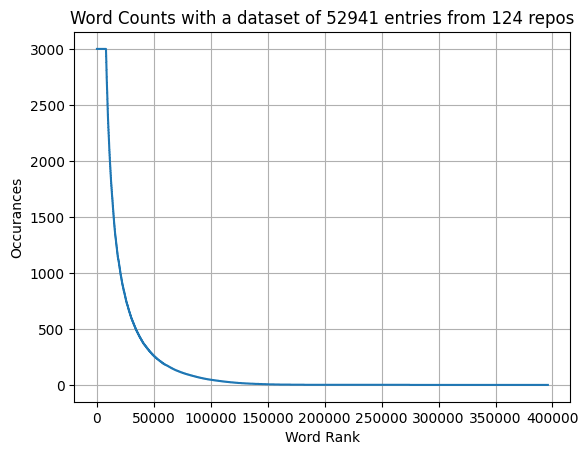

395945
9000


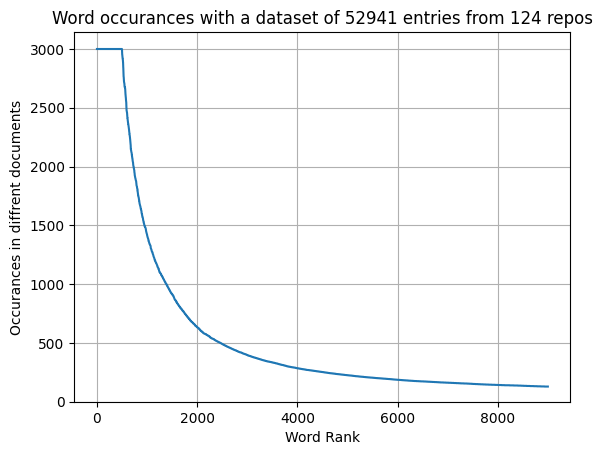

In [106]:
#print(tokenizer.word_counts)

#print a graph of the word counts
wordCounts = tokenizer.word_counts
wordCounts = sorted(wordCounts.items(), key=lambda x: x[1], reverse=True)
wordCounts = dict(wordCounts)
wordCounts = list(wordCounts.values())
#get mean word count



meanWordCount = np.mean(wordCounts)

#get the median word count
medianWordCount = np.median(wordCounts)

print("Mean Word Count: ", meanWordCount)
print("Median Word Count: ", medianWordCount)
wordCounts = wordCounts
wordCounts = np.clip(wordCounts, 0, 3000)

#graph the word counts with a grid
plt.plot(wordCounts)
plt.ylabel('Occurances')
plt.xlabel('Word Rank')
plt.title('Word Counts with a dataset of ' + str(len(dataSet1)) + ' entries from ' + str(len(df)) + ' repos')
plt.grid(True)
plt.show()

#graph the amound of words that appear in each file
fileWordCounts = tokenizer.word_docs
#translate the words to their tokens
fileWordCounts = sorted(fileWordCounts.items(), key=lambda x: x[1], reverse=True)
fileWordCounts = dict(fileWordCounts)
#create a list of dict keys
fileWordCountsKey = list(fileWordCounts.keys())
print (len(fileWordCountsKey))
wordIndex = tokenizer.word_index
fileWordCountTokenConversion = []
for i in fileWordCounts:
    tken = wordIndex[i]
    fileWordCountTokenConversion.append(tken)
 

#create a list of FileWordCountTokenConversion and fileWordCounts values combined
fileWordCounts = list(fileWordCounts.values())
fileWordCounts = np.clip(fileWordCounts, 0, 300000000000000000000000000)
fileWordCounts = list(zip(fileWordCountTokenConversion, fileWordCounts))
fileWordCounts = sorted(fileWordCounts, key=lambda x: x[1], reverse=True)
fileWordCounts = dict(fileWordCounts)
fileWordCounts = list(fileWordCounts.values())
#get rid of the bottom results
fileWordCounts = fileWordCounts[0:9000]
#graph the word counts with a grid
plt.plot(np.clip(fileWordCounts,0,3000))
plt.ylabel('Occurances in diffrent documents')
plt.xlabel('Word Rank')
plt.title('Word occurances with a dataset of ' + str(len(dataSet1)) + ' entries from ' + str(len(df)) + ' repos')
plt.grid(True)
#make 0 show on y axis
plt.ylim(ymin=0)
print (len(fileWordCounts))

In [15]:
#get the ammounts of tokens in the data set
from tokenize import TokenInfo




#print(tokenizer.word_index)

#print(tokenizer.word_counts)

print(tokenizer.word_docs)
print(tokenizer.word_index)
print(tokenizer.document_count)
print(tokenizer.num_words)
print(tokenizer.index_docs)
print(tokenizer.index_word)
print(tokenizer.word_counts)
print(tokenizer.word_docs)
print(tokenizer.word_index)
print(tokenizer.document_count)
print(tokenizer.num_words)
print(tokenizer.index_docs)
print(tokenizer.index_word)


print(dataSet1.memory_usage(deep=True).sum()/1024/1024)
#print a short version of X[0]
print(dataSet1[dataSet1.columns[0]][0])
#print data converted to text to see if it is correct
    
print(tokenizer.sequences_to_texts(dataSet1[dataSet1.columns[0]][0]))
print(dataSet1[dataSet1.columns[0]][1])


NameError: name 'tokenizer' is not defined

In [4]:
from tokenize import TokenInfo
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers import Conv2D

model = Sequential()

#delete the data row of dataSet1

#get the number of unique words in the dataset
model.add(Embedding(maxWords+1, 64, input_length=X.shape[1]))
#model.add(Conv1D(1024, 20, activation='relu')) 
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(128)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())
model.compile( loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
hist = model.fit(X, np.array(dataSet1['grade'].to_list()),validation_split=0.2, epochs=2, verbose=1)
# evaluate the model
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#save the model
#model.save('model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13117, 64)         96064     
                                                                 
 bidirectional (Bidirectiona  (None, 13117, 256)       197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 696,193
Trainable params: 696,193
Non-trai

In [ ]:
#save the tokenizer
path = 'D:\\models\\python\\'
modelName = 'python_model_1_IMPROVED'
import pickle

#make the directory if it does not exist
if not os.path.exists(path):
    os.makedirs(path)

#make the modelName directory if it does not exist
if not os.path.exists(path+modelName):
    os.makedirs(path+modelName)

with open(path + modelName + '\\tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#save the model
model.save(path + modelName + '\\model.h5')

#save info about the model
import json
modelInfo = {'maxWords': maxWords, 'maxLen': maxLen}
with open(path + modelName + '/modelInfo.json', 'w') as outfile:
    json.dump(modelInfo, outfile)
    outfile.close()
    
#save Model Stats (hist.history)
with open(path + modelName + '/modelStats.json', 'w') as outfile:
    json.dump(hist.history, outfile)
    outfile.close()
    




In [ ]:
#load the model
path='D:/Models/'
modelName = 'firstTest'
from keras.models import load_model
model = load_model(path + modelName + '/model.h5')

#load the tokenizer
import pickle
with open(path + modelName + '/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#load the model info
import json
with open(path + modelName + '/modelInfo.json') as json_file:
    modelInfo = json.load(json_file)


In [ ]:
"""For comparison, 1000 randomly generated numbers from 1-100 generated and have statistic analysis performed on them"""
randomgrades = []
randomgrades2 = []
import random
import statistics

from sklearn.metrics import mean_absolute_percentage_error
for i in range(1000):
    randomgrades.append(random.randint(1,100))
    randomgrades2.append(random.randint(1,100))

print("Random Grades")
#mean squared error
print("Mean Squared Error: ", mean_squared_error(randomgrades, randomgrades2))
#mean absolute error'
print("Mean Absolute Error: ", mean_absolute_error(randomgrades, randomgrades2))
#mean absolute percentage error
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(randomgrades, randomgrades2))

In [137]:
grade = []

In [ ]:
#print the tokenizer word index
print(tokenizer.word_index)

In [138]:
#open a file and store the data in a variable
data = open("C:\\Users\\Mcall\Desktop\\IT100L-Programming-Logic-and-Design-Laboratory-Course-main\\Activity4\\Activty2.py", 'r', encoding="utf8")
dataread = data.read()
#close the file
data.close()

dataread = stringProcessing(dataread)

dataread = padSymbols(dataread)

#tokenize the data
tokens = tokenizer.texts_to_sequences([dataread])
#pad the data
tokens = pad_sequences(tokens, maxlen=X.shape[1])
#predict the grade
grade.append(model.predict(tokens).tolist()[0][0])
print(grade)

1/1 [==============================] - 0s 322ms/step
[37.02326583862305]


In [ ]:
print("test")

In [ ]:
#Load a 2nd model
path='D:\\Models\\python\\'
modelName = 'python_model_1'

from keras.models import load_model
model2 = load_model(path + modelName + '\\model.h5')

#load the tokenizer
import pickle
with open(path + modelName + '\\tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)

#load the model info
import json
with open(path + modelName + '\\modelInfo.json') as json_file:
    modelInfo2 = json.load(json_file)

In [ ]:



#open a file and store the data in a variable
data = open("C:\\Users\\Mcall\Desktop\\IT100L-Programming-Logic-and-Design-Laboratory-Course-main\\Activity4\\Activty2.py", 'r', encoding="utf8")
datareaded = data.read()
#close the file
data.close()

dataread = stringProcessing(datareaded)

datareaded = padSymbols(datareaded)

#tokenize the data
tokens = tokenizer2.texts_to_sequences([datareaded])
#pad the data
tokens = pad_sequences(tokens, maxlen=X.shape[1])
#predict the grade
grade.append(model2.predict(tokens).tolist()[0][0])
print(grade)